In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.signal import butter, cheby1, filtfilt, lfilter, ellip
from IPython.display import Audio


## Plotting

In [18]:
def plotSignal(data, title = "Waveform"):
    plt.figure()
    plt.plot(data)
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.title('Waveform of Test Audio')
    plt.show()


def plotSignal_Freq(data, fs, title=''):
    n = len(data)
    fft_data = np.fft.fft(data)
    fft_magnitude = np.abs(fft_data) / n
    frequencies = np.fft.fftfreq(n, d=1/fs)
    fft_magnitude_shifted = np.fft.fftshift(fft_magnitude)
    frequencies_shifted = np.fft.fftshift(frequencies)
    plt.plot(frequencies_shifted, fft_magnitude_shifted)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.show()


## Filters

In [19]:
# Low Pass Filters

def lowpass_filter_ellip(data, cutoff, fs, order=5, rp=0.1, rs=60):
    filter = ellip(order, rp, rs, cutoff, btype='lowpass', fs=fs, output='ba')
    return lfilter(*filter, data)


def lowpass_filter_butter(data, cutoff, fs, order=5):
    filter = butter(order, cutoff, btype='lowpass', fs=fs, output='ba')
    return filtfilt(*filter, data)


def lowpass_filter_ideal(data, cutoff, fs):
    n = len(data)
    fft_data = np.fft.fft(data)
    frequencies = np.fft.fftfreq(n, d=1/fs)
    fft_data[np.abs(frequencies) > cutoff] = 0
    return np.real(np.fft.ifft(fft_data))

def lowpass_filter_cheby1(data, cutoff, fs, order=5, rp=0.1):
    filter = cheby1(order, rp, cutoff, btype='lowpass', fs=fs, output='ba')
    return lfilter(*filter, data)

# Band Pass Filters

def bandpass_filter_ellip(data, begin, end, fs, order=5, rp=0.1, rs=60):
    filter = ellip(order, rp, rs, [begin, end], btype='bandpass', fs=fs, output='ba')
    return lfilter(*filter, data)

def bandpass_filter_butter(data, begin, end, fs, order=5):
    filter = butter(order, [begin, end], btype='bandpass', fs=fs, output='ba')
    return lfilter(*filter, data)

def bandpass_filter_ideal(data, begin, end, fs):
    n = len(data)
    n = len(data)
    fft_data = np.fft.fft(data)
    frequencies = np.fft.fftfreq(n, d=1/fs)
    fft_data[(np.abs(frequencies) > end) | (np.abs(frequencies) < begin)] = 0
    return np.real(np.fft.ifft(fft_data))

def bandpass_filter_cheby1(data, begin, end, fs, order=5, rp=0.1):
    filter = cheby1(order, rp, [begin, end], btype='bandpass', fs=fs, output='ba')
    return lfilter(*filter, data)

# Generic Filters

def lowpass_filter(data, cutoff, fs, filter_type='butter'):
    
    if filter_type == 'butter':
        return lowpass_filter_butter(data, cutoff, fs)
    elif filter_type == 'ideal':
        return lowpass_filter_ideal(data, cutoff, fs)
    elif filter_type == 'cheby1':
        return lowpass_filter_cheby1(data, cutoff, fs)
    elif filter_type == 'ellip':
        return lowpass_filter_ellip(data, cutoff, fs)
    else:
        raise ValueError('Invalid filter type')
    

def bandpass_filter(data, begin, end, fs,  filter_type='butter'):
    
    if filter_type == 'butter':
        return bandpass_filter_butter(data, begin, end, fs)
    elif filter_type == 'ideal':
        return bandpass_filter_ideal(data, begin, end, fs)
    elif filter_type == 'cheby1':
        return bandpass_filter_cheby1(data, begin, end, fs)
    elif filter_type == 'ellip':
        return bandpass_filter_ellip(data, begin, end, fs)
    else:
        raise ValueError('Invalid filter type')


## Carrier

In [20]:
def generate_carrier(fc, fs, duration):
    t = np.arange(0, duration, 1/fs)
    return np.cos(2*np.pi*fc*t)

## Loading Tests

In [21]:
def loadTests(files, FS, filter_type):
    data = []
    for file in files:
        fs, d = read(file)

        ten_seconds = 10 * fs


        if fs != FS:
            raise ValueError("Sampling rate of file does not match the desired sampling rate")
        
        d = d[:ten_seconds,0]

        filename = file.split('/')[-1]


        plotSignal_Freq(d, fs, 'Original Signal ' + filename)
        d = lowpass_filter(d, 3500, fs, filter_type)
        # d = bandpass_filter(d, 500, 3200, fs, 'butter')
        plotSignal_Freq(d, fs, 'Lowpass Filtered Signal ' + filename)

        data.append(d)

    return data

## SSB 

In [22]:
def modulate(data, fc, fs, maxfreq, filter_type):
    carrier = generate_carrier(fc, fs, len(data)/fs)
    modulated = data * carrier

    return bandpass_filter(modulated, fc, fc + maxfreq , fs, filter_type)


def FDM(signals, frequencies, fs, filter_type):
    
    modulated = np.zeros(len(signals[0]))
    for i in range(len(signals)):
        modulated_signal = modulate(signals[i], frequencies[i], fs, 3500, filter_type)
        plotSignal_Freq(modulated_signal, fs)
        modulated += modulated_signal
    return modulated

def demodulate(data, fc, fs, maxfreq, filter_type):
        
    filtered_data = bandpass_filter(data, fc, fc + maxfreq, fs, filter_type)

    carrier = generate_carrier(fc, fs, len(data)/fs)
    demodulated = filtered_data * carrier

    return lowpass_filter(demodulated, maxfreq, fs, filter_type)



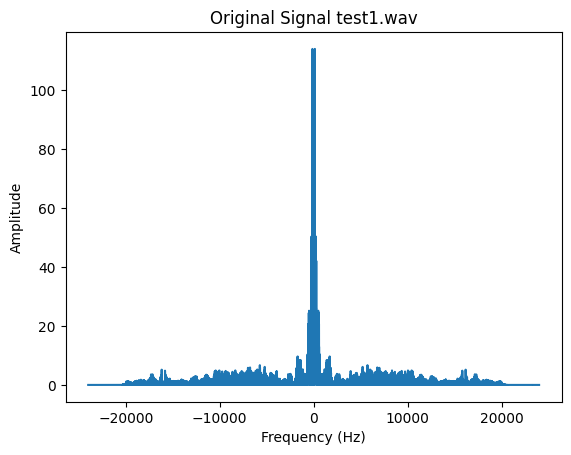

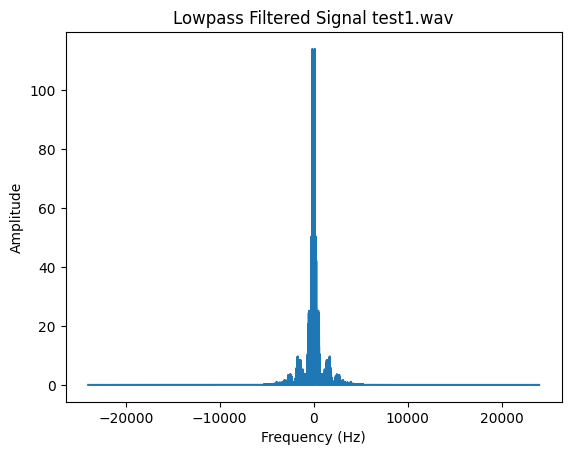

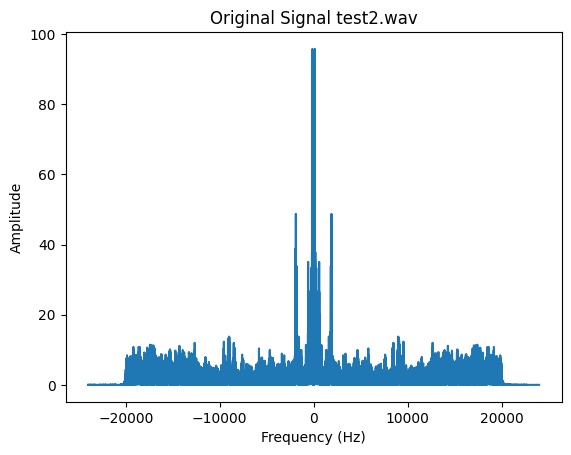

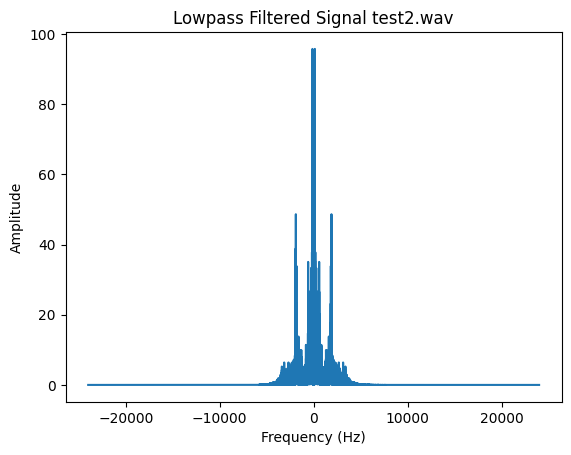

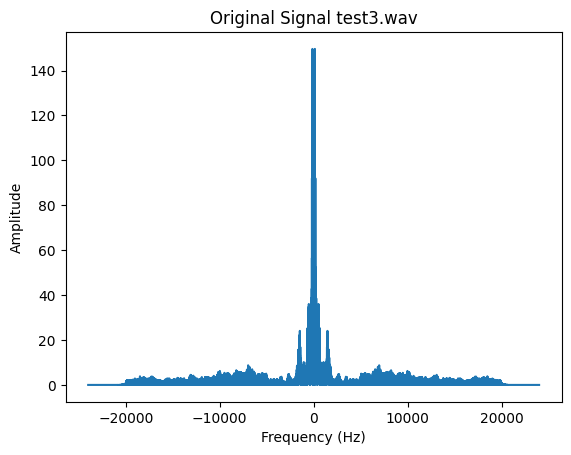

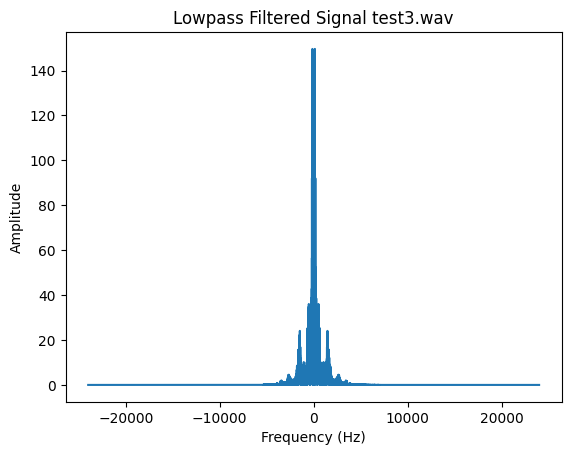

In [23]:
FS = 48000

filter_type = 'butter'

files = ['inputs/test1.wav', 'inputs/test2.wav', 'inputs/test3.wav']
signals = loadTests(files, FS, filter_type)

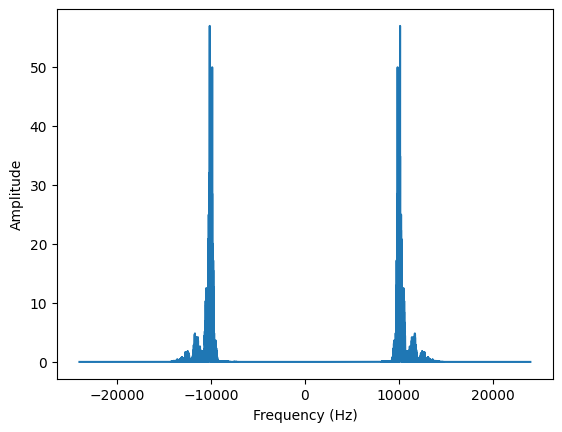

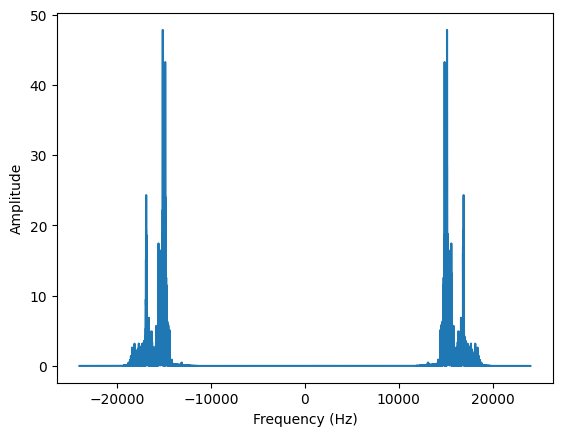

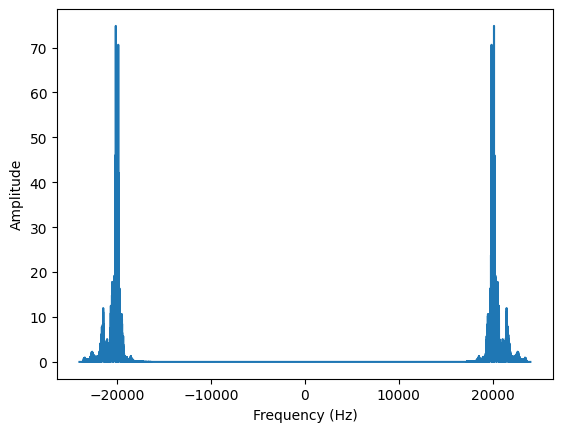

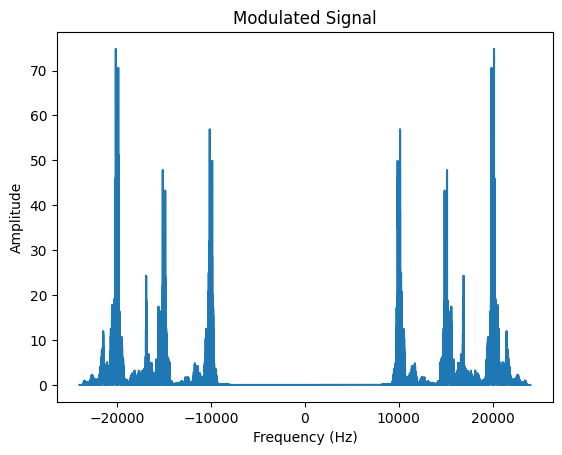

In [24]:
frequencies = [10000, 15000, 20000]
filter_type = 'cheby1'

modulated = FDM(signals, frequencies, FS, filter_type)

plotSignal_Freq(modulated, FS, 'Modulated Signal')

In [25]:
frequencies = [10000, 15000, 20000]

filter_type = 'cheby1'

signal1 = demodulate(modulated, frequencies[0], FS, 3500, filter_type)
signal2 = demodulate(modulated, frequencies[1], FS, 3500, filter_type)
signal3 = demodulate(modulated, frequencies[2], FS, 3500, filter_type)

In [37]:
write('outputs/test1.wav', FS, signal1.astype(np.int16))
write('outputs/test2.wav', FS, signal2.astype(np.int16))
write('outputs/test3.wav', FS, signal3.astype(np.int16))